In [1]:
#Append path to Ruomin's Edamame Package (Nanowire Simulations)
import sys
sys.path.append('/import/silo2/aloe8475/Documents/edamame')
saveFig='/import/silo2/aloe8475/Documents/Data/Figures/Functional Connectivity/'

In [2]:
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from numpy import linalg
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.lines as mlines
from matplotlib import colors
import pandas as pd
import skspatial
from skspatial.objects import Plane, Points
from skspatial.plotting import plot_3d
import copy


from scipy.io import loadmat, savemat
from scipy import signal

#Import Ruomin's package
from edamame import * 


#import networkx for visualisation of networks
import networkx as nx

#tqdm allows for progress bars
from tqdm.notebook import tqdm_notebook as tqdm

import os
from IPython.core.debugger import set_trace
import matplotlib.colors as clrs


In [3]:
# GENERATE + LOAD CSV FILE OF IMAGES:
from learning_functions import generate_data, load_data
generate_data()
inputs,onehot_outputs,sample_num,targets=load_data()
target_letters=['z','v','n']
inv_inputs = np.linalg.pinv(inputs)


In [4]:
inputs=inputs[:,:-1]

In [5]:
#change 0 volts to 0.05
inputs[inputs==0]=0.05

In [6]:
inputs

array([[1.  , 1.  , 1.  , 0.05, 1.  , 0.05, 1.  , 1.  , 1.  ],
       [0.05, 1.  , 1.  , 0.05, 1.  , 0.05, 1.  , 1.  , 1.  ],
       [1.  , 0.05, 1.  , 0.05, 1.  , 0.05, 1.  , 1.  , 1.  ],
       [1.  , 1.  , 0.05, 0.05, 1.  , 0.05, 1.  , 1.  , 1.  ],
       [1.  , 1.  , 1.  , 1.  , 1.  , 0.05, 1.  , 1.  , 1.  ],
       [1.  , 1.  , 1.  , 0.05, 0.05, 0.05, 1.  , 1.  , 1.  ],
       [1.  , 1.  , 1.  , 0.05, 1.  , 1.  , 1.  , 1.  , 1.  ],
       [1.  , 1.  , 1.  , 0.05, 1.  , 0.05, 0.05, 1.  , 1.  ],
       [1.  , 1.  , 1.  , 0.05, 1.  , 0.05, 1.  , 0.05, 1.  ],
       [1.  , 1.  , 1.  , 0.05, 1.  , 0.05, 1.  , 1.  , 0.05],
       [1.  , 0.05, 1.  , 0.05, 1.  , 0.05, 0.05, 1.  , 0.05],
       [0.05, 0.05, 1.  , 0.05, 1.  , 0.05, 0.05, 1.  , 0.05],
       [1.  , 1.  , 1.  , 0.05, 1.  , 0.05, 0.05, 1.  , 0.05],
       [1.  , 0.05, 0.05, 0.05, 1.  , 0.05, 0.05, 1.  , 0.05],
       [1.  , 0.05, 1.  , 1.  , 1.  , 0.05, 0.05, 1.  , 0.05],
       [1.  , 0.05, 1.  , 0.05, 0.05, 0.05, 0.05, 1.  ,

In [7]:
from learning_functions import genGridNW,point_on_line,dist,getWeightedGraph

In [8]:
pwd

'/import/silo2/aloe8475/Documents/CODE/Analysis/Training/Associative Learning/Natesh_3x3'

In [9]:
#load SPARSE network
#Not you need this file in a folder called Sparse Networks 
# asn_nw_00300_nj_00621_seed_1252_avl_10.00_disp_01.00_lx_100.00_ly_100.00
#asn_nw_00350_nj_01400_seed_2665_avl_10.00_disp_01.00_lx_50.00_ly_50.00
#asn_nw_00250_nj_00794_seed_134_avl_10.00_disp_01.00_lx_50.00_ly_50.00
nw=loadmat('/import/silo2/aloe8475/Documents/Data/Associative Learning/Sparse Networks/asn_nw_00350_nj_01350_seed_1581_avl_10.00_disp_01.00_lx_50.00_ly_50.00')
this_seed=8639#np.random.randint(10000) #random seed
Network=nw#edamame.core.generate_network(300,dispersion=350,mean_length=200,this_seed=this_seed)
connectivity=connectivity__(wires_dict=Network) 

In [10]:
#fixing file structure from Matlab:
connectivity.avg_length=connectivity.avg_length[0][0]
connectivity.number_of_junctions=connectivity.number_of_junctions[0][0]
connectivity.centroid_dispersion=connectivity.centroid_dispersion[0][0]
connectivity.dispersion=connectivity.dispersion[0][0]
# connectivity.generating_number_of_wires=connectivity.generating_number_of_wires[0][0]
connectivity.gennorm_shape=connectivity.gennorm_shape[0][0]
connectivity.length_x=connectivity.length_x[0][0]
connectivity.length_y=connectivity.length_y[0][0]
connectivity.number_of_wires=connectivity.number_of_wires[0][0]
connectivity.numOfWires=connectivity.numOfWires[0][0]
connectivity.numOfJunctions=connectivity.numOfJunctions[0][0]
connectivity.theta=connectivity.theta[0][0]
connectivity.this_seed=connectivity.this_seed[0][0]

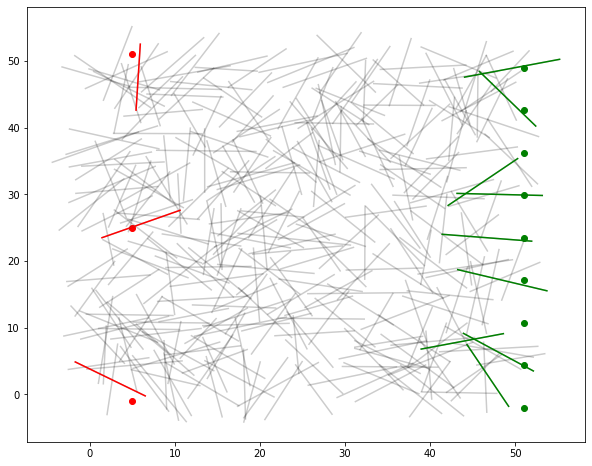

In [11]:
#Generate Network
%matplotlib inline

#find x and y values of each end of each wire 
xa=connectivity.xa[0]
xb=connectivity.xb[0]
ya=connectivity.ya[0]
yb=connectivity.yb[0]

#Pick Electrode placement/distance apart:

#DRAINS
numDrains=3
ex=np.ones(numDrains)*5#*15
# ey=np.linspace(0,550,numDrains)
ey=np.linspace(-1,51,numDrains)#(50,100,numDrains)

elecDrain=genGridNW(xa,xb,ya,yb,ex,ey) #generate drain locations in ex, ey coordinates

plt.figure(figsize=(10,8))
plt.scatter(ex, ey, c = 'r')

#SOURCES
numSources=9


#IN A LINE:
ex=np.ones(numSources)*51#95
ey=np.linspace(-2,49,numSources)#(35,100,numSources)
#IN A 3X3 GRID:
# middleNWx=int(connectivity.length_x/2)+1
# middleNWy=int(connectivity.length_y/2)-1
# distBwElecs=10
# ex=[middleNWx-distBwElecs,middleNWx-distBwElecs,middleNWx-distBwElecs,middleNWx,middleNWx,middleNWx,middleNWx+distBwElecs,middleNWx+distBwElecs,middleNWx+distBwElecs]
# ey=[middleNWy-distBwElecs,middleNWy,middleNWy+distBwElecs]*3

elecSource=genGridNW(xa,xb,ya,yb,ex,ey) #generate source locations in ex, ey coordinates

plt.plot([xa, xb], [ya, yb], c = 'k',alpha=0.2)
plt.plot([xa[elecDrain], xb[elecDrain]], [ya[elecDrain], yb[elecDrain]], c = 'r')
plt.plot([xa[elecSource], xb[elecSource]], [ya[elecSource], yb[elecSource]], c = 'g')

plt.scatter(ex, ey, c = 'g')

# plt.savefig(figLoc+'Network and Electrodes.png',dpi=300)

In [12]:
print('OG Sources:' + str(elecSource))
print('OG Drains:' + str(elecDrain))

OG Sources:[183 322 194  74 145 317 196 342 141]
OG Drains:[296 249 339]


In [13]:
#MANUAL SOURCES DRAINS IF THERE'S OVERLAP
elecSource=[23,320,26,74,145,317,129,247,141] #elecSource=[39,253,155,33,271,25,185,163,256]
elecDrain=[296,249,25]#elecDrain=[306,317,53]

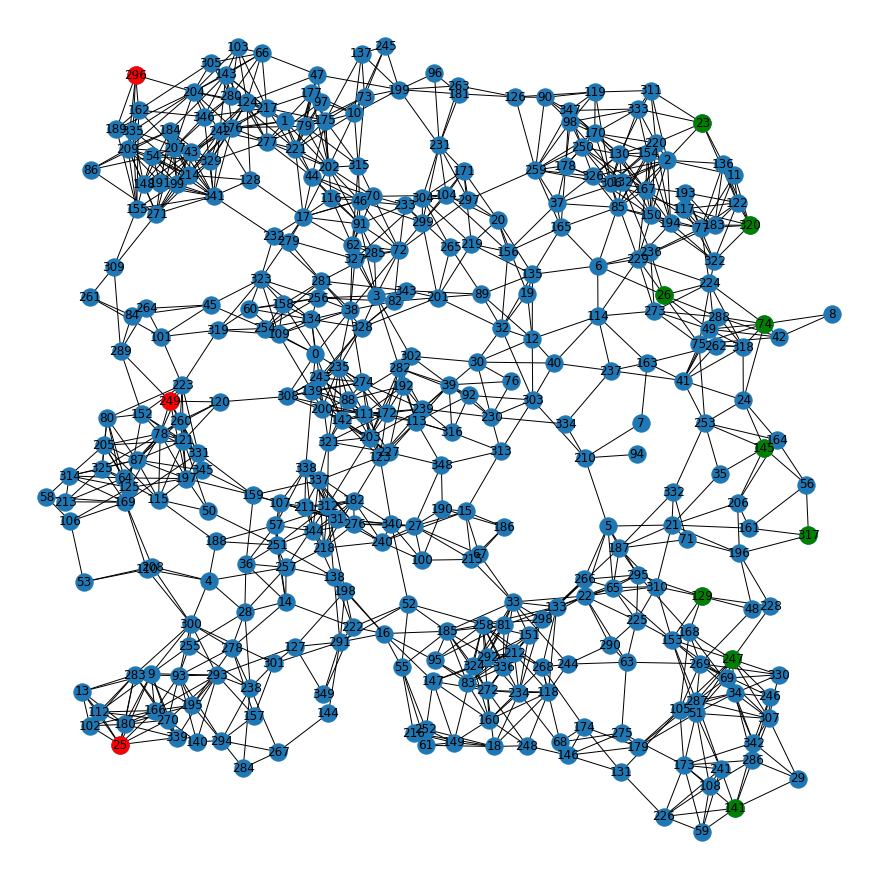

In [14]:
#PLOT GRAPH REPRESENTATION:
plt.figure(figsize=(12,12))
pos=nx.kamada_kawai_layout(nx.from_numpy_array(connectivity.adj_matrix))
nx.draw(nx.from_numpy_array(connectivity.adj_matrix),pos=pos,with_labels=True)
nx.draw_networkx_nodes(elecSource,node_color='g',pos=pos)
nx.draw_networkx_nodes(elecDrain,node_color='r',pos=pos)

In [15]:
#This function sets up the stimuli for simulations. 
def setupStimulus(training_stimulus,currInput,run_time=2,onAmp=1,signalType='DC'):

    for i in range(num_drain_training):
        training_stimulus.append((stimulus__(biasType='Drain',T=run_time,dt=dt)))
        
    #Sources
    for i in range(len(currInput)):
        if currInput[i]>0:
            training_stimulus.append((stimulus__(biasType=signalType,onAmp=onAmp*currInput[i],T=run_time,dt=dt)))
#         else: #non-active sources are changed to 0.005 instead of 0, to reduce sink behaviour between sources
#             training_stimulus.append((stimulus__(biasType=signalType,onAmp=0.01,T=run_time,dt=dt)))

    return training_stimulus

In [16]:
#This function sets up the stimuli for the testing part of the simulation. 
def setupSourcesOnly(stim,currInput,onAmp=1,run_time=2,signalType='DC'):
    #Sources
    stimulus=copy.deepcopy(stim)
    for i in range(len(currInput)):
        if currInput[i]>0:
            stimulus.append((stimulus__(biasType=signalType,onAmp=onAmp*currInput[i],T=run_time,dt=dt)))
#         else:
#             stimulus.append((stimulus__(biasType=signalType,onAmp=0.01,T=run_time,dt=dt)))
    return stimulus

In [17]:
#This function runs each training epoch and saves the network state at the last timestep of that epoch

def getNWState(training_stimulus,state,drain_pool,sources,run_time=2):
    eles = np.append(drain_pool, sources) #all drains
#     if len(eles) == num_drain_training + num_source_training:
    training_sim = runSim(connectivity, stimulus = training_stimulus,
                       junctionMode = 'tunneling',
                       dt = dt, T = run_time, 
                       contactMode = 'preSet',
                       electrodes = eles,
                       findFirst = False,
                       start_state = state,
                       disable_tqdm=True)
                       #criticalFlux=0.01)  
    JS1 = getJunctionState(training_sim, -1) #save state
#     else: 
#         print('Bless you Joel :)')
    return training_sim,JS1

In [18]:
#This function calculates the conductance read out at each drain electrode, 
#which we use to determine if the target threshold for each electrode is met

def calcOutputs(sim2, sources,all_drains):
    
    cc = [None]*len(all_drains)#np.zeros(len(all_drains))
    volt = [None]*len(all_drains)#np.zeros(len(all_drains))

# ALTERNATIVE METHOD SUGGESTED BY JOEL

#Index network state:
    #IF PULSE - we want the state of the network at the end of the last pulse 
#     if sim2.stimulus[-1].biasType=='Pulse':
#         t=sim2.stimulus[-1].signal>0.005
#         idx=[i for i, x in enumerate(t) if x][-1]
#     else: #otherwise we take 4 timesteps as the state of the network 
#         idx=[500,1000,1500,-1]
#         idx=-1
        
        
#Calculate Current at network state: 
    for i, d in enumerate(all_drains): #for each drain electrode
        #current
        cc[i]=sim2.electrodeCurrent.T[i]#[idx]#/(sim2.wireVoltage.T[sources[0]][idx]-sim2.wireVoltage.T[d][idx])
        #resistance
        volt[i]=sim2.wireVoltage.T[d]#[idx]#/sim2.electrodeCurrent.T[i][idx]
        
        # Conductance = Current Drain / (Voltage Source - Voltage Drain)
    return cc,volt


In [19]:
#Calculate cost function
def calc_cost(x,y):
    return (1/2)*((x-y)**2)
#we need to account for the fact where some non-target drains will have -ve current that impacts the +ve current drains

In [20]:
#This function changes the write voltage of the drain electrodes. This is where we tune the system so that 
#it prioritises/de-prioritises certain pathways based on targets and non-targets
def change_voltage(stim,sim2,outputVals,target_index,th=0,th2=0,signalType='DC'):
    import copy
    stimulus=copy.deepcopy(stim)
    
    Vi        = np.zeros((int(run_time/dt)))
    maxV      = onAmp*0.75
    n         = len(outputVals)
    cost      = np.zeros(n)
    beta      = 0.1 #change the values here
    grad      = np.zeros((n))
    dsig    = np.array([stimulus[i].signal for i in range(len(stimulus))][:num_drain_training])
    
    #vectorised implementation
    cost=calc_cost(outputVals,target_values) 
    
#     if gradOff == False: #
    grad=beta*(outputVals-target_values) 
#     elif gradOff == True: #if we have hit currents target
#         grad=0
    dsig2=dsig.T+(grad*onAmp)
    for i in range(n): # for each drain:
        if stimulus[i].signal[0] <= maxV and stimulus[i].signal[0] >= -maxV:
            stimulus[i].signal=dsig2.T[i]
        
    print('Costs '+str(cost))
    print('Sum Cost '+str((np.sum(cost))))
    print('Gradients '+str(grad))
    return outputVals,stimulus,cost

In [21]:
#This is how we test new inputs - only care about cost
def runTesting(outputVals,th,th2):
    n     = len(outputVals)   
    cost=calc_cost(outputVals,target_values) 
    return cost


In [22]:
sources = elecSource
drain_pool = elecDrain
allTargets=[[1,0,0],[0,1,0],[0,0,1]]#onehot_outputs#
numSamples=10

In [27]:
#Associative Learning to find max currents for each drain:
numClasses=3
onAmp = 1
signalType='DC'
run_time=1
dt=0.01
num_drain_training=1
num_source_training=9
t=[None]*numClasses
sim=[None]*numClasses
state=[None]*numClasses
numTrainingSamples=8
rest=[0]*9
restDur=10
trainOrder=np.array(range(numTrainingSamples))
np.random.shuffle(trainOrder)


for classNum in tqdm(range(numClasses)):
    targetClass   = classNum #'z','v','n'
    target_values = allTargets[targetClass]
    chosenDrain   = drain_pool[targetClass]
    if len(elecDrain) == 3:
        targetClassVals=[0,1,2]
    else:
        targetClassVals=[0,1,2,3]
        target_values=np.hstack((target_values,0)) #add extra 0 for 4th drain that acts just to balance the network

    trainingInputs  = inputs[targets==targetClassVals[targetClass]][:-2]
    testingInputs   = inputs[targets==targetClassVals[targetClass]][-2:]
    
    #expand each value to run the number of timesteps:
    newRow=np.zeros((len(trainingInputs),int(run_time/dt)+restDur,9))
    count=0
    for i in trainingInputs[trainOrder]:
        for j in range(int(run_time/dt)+restDur):
            if j < int(run_time/dt):
                newRow[count][j]=i
            else:
                newRow[count][j]=rest
        count=count+1
    stimulus=np.concatenate(newRow,axis=0).T*onAmp

    newSignal=[]
    for i in range(num_drain_training):
        newSignal.append(stimulus__(biasType='Drain',T=dt*stimulus.shape[1],dt=dt))
    for i in range(len(stimulus)):
        newSignal.append(stimulus__(biasType='Custom',onAmp=onAmp,T=dt*stimulus.shape[1],dt=dt,customSignal=stimulus[i]))
#     set_trace()
    sim[classNum] = getNWState(newSignal,None,[chosenDrain],sources,run_time=len(newSignal[0].signal)*dt)


In [28]:
#find max current:
maxDrain1=np.max(sim[0][0].electrodeCurrent.T[0])
maxDrain2=np.max(sim[1][0].electrodeCurrent.T[0])
maxDrain3=np.max(sim[2][0].electrodeCurrent.T[0])

In [29]:
#loop through classes and set inputs
trainingInputs  = np.array([inputs[targets==targetClassVals[0]][:-2],inputs[targets==targetClassVals[1]][:-2],inputs[targets==targetClassVals[2]][:-2]]).reshape(-1,9)
testingInputs   = np.array([inputs[targets==targetClassVals[0]][-2:],inputs[targets==targetClassVals[1]][-2:],inputs[targets==targetClassVals[2]][-2:]]).reshape(-1,9)

In [30]:
#How many times we want to show each sample:
traininglabels=np.zeros(len(trainingInputs))
traininglabels[:8]=0
traininglabels[8:16]=1
traininglabels[16:]=2
traininglabels=traininglabels.astype(int)

testinglabels=np.zeros(len(testingInputs))
testinglabels[:2]=0
testinglabels[2:4]=1
testinglabels[4:]=2
testinglabels=testinglabels.astype(int)

order=range(len(inputs))
# order=np.matrix(np.zeros((len(inputs),1)))
# perm=np.matrix(np.random.permutation(len(inputs)))
# order+=perm.T
# order=np.array(order.reshape(-1))[0].astype(int)


In [35]:
#Associative Learning with all training samples + backprop

maxCurrent          = [maxDrain1,maxDrain2,maxDrain3]
numClasses          = 3
onAmp               = 0.75
signalType          ='DC'
num_drain_training  = 3
num_source_training = 9
t                   = [None]*len(order)
tmpSources          = [[] for i in range(len(order))]
tmpTargets          = [None]*len(order)
sim                 = [None]*len(order)
numTrainingSamples  = 8

#Sim Duration:
dt      = 0.01
numDT   = 1000 #number of timesteps per sample
rest    = [0]*9
restDur = 0 #number of rest timesteps between samples


#Randomise classes:
for i in range(len(order)): #this method loops through samples
    if i < len(order)-len(testingInputs):
        this_sample = trainingInputs[order[i]] #xs
        this_label  = traininglabels[order[i]] #ys
    else:
        ii = i- (len(order)-len(testingInputs))
        this_sample = testingInputs[order[ii]] #xs
        this_label  = testinglabels[order[ii]] #ys

    targetClassVals=[0,1,2] 

    targetTmp = signal_expand(this_label,numDT) #number of timesteps per target
    targetTmp = np.append(targetTmp,np.zeros(restDur)) #add rest
    tmpTargets[i]=targetTmp 

    for j in range(len(this_sample)): #for each source electrode
        tmp = signal_expand(this_sample[j],numDT) #number of timesteps per sample (same as target)
        tmp = np.append(tmp,np.zeros(restDur)) #add rest
        tmpSources[i].append(tmp) 
        
#reshape stimulus[i] into 1d:
tmpSources = np.hstack(np.array(tmpSources))
tmpTargets = np.hstack(np.array(tmpTargets)).astype(int)

trainTime  = (len(order)-len(testingInputs))*1000
testTime   = len(testingInputs)*1000

tmpDrain=[]
stimulus=[]
for j in range(num_drain_training): #create stimulus for each drain electrode
    stimulus.append(stimulus__(biasType='Drain',T=dt*len(tmpSources[j]),dt=dt))
    
for j in range(len(tmpSources)): #create stimulus for each source electrode
    stimulus.append(stimulus__(biasType='Custom',onAmp=onAmp,T=dt*len(tmpSources[j]),dt=dt,customSignal=tmpSources[j]))

signalLen=len(stimulus[0].signal) 

#Run simulation
sim,cost = getNWState_backprop(stimulus,None,drain_pool,sources,run_time=int(signalLen*dt),disable_tqdm=False)
#Calculate electrode currents
t,v = calcOutputs(sim,sources,drain_pool)
    
#if we want only one drain, use [chosenDrain] instead of drain_pool


Training
[1, 0, 0]
[0.00000000e+00 5.60525371e-05 3.87028694e-05]
[1, 0, 0]
[0.         0.53130816 0.61517351]
[1, 0, 0]
[0.         0.56049109 0.61894694]
[0, 1, 0]
[0.36351359 0.         0.24984888]
[0, 1, 0]
[0.26424478 0.         0.21114015]
[0, 1, 0]
[0.38254486 0.         0.29708309]
[0, 0, 1]
[0.41903507 0.40372862 0.        ]
[0, 0, 1]
[0.51681993 0.42589245 0.        ]
Testing



Text(0, 0.5, 'Current')

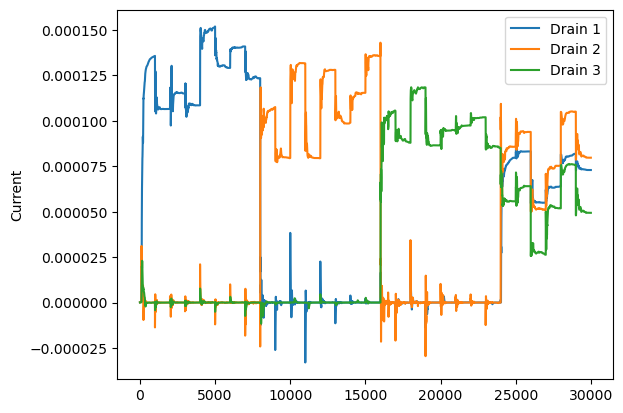

In [38]:
plt.rcParams.update(plt.rcParamsDefault)

plt.plot(t[0])
plt.plot(t[1])
plt.plot(t[2])
plt.legend(['Drain 1','Drain 2','Drain 3'])
plt.ylabel('Current')
# print(labels)

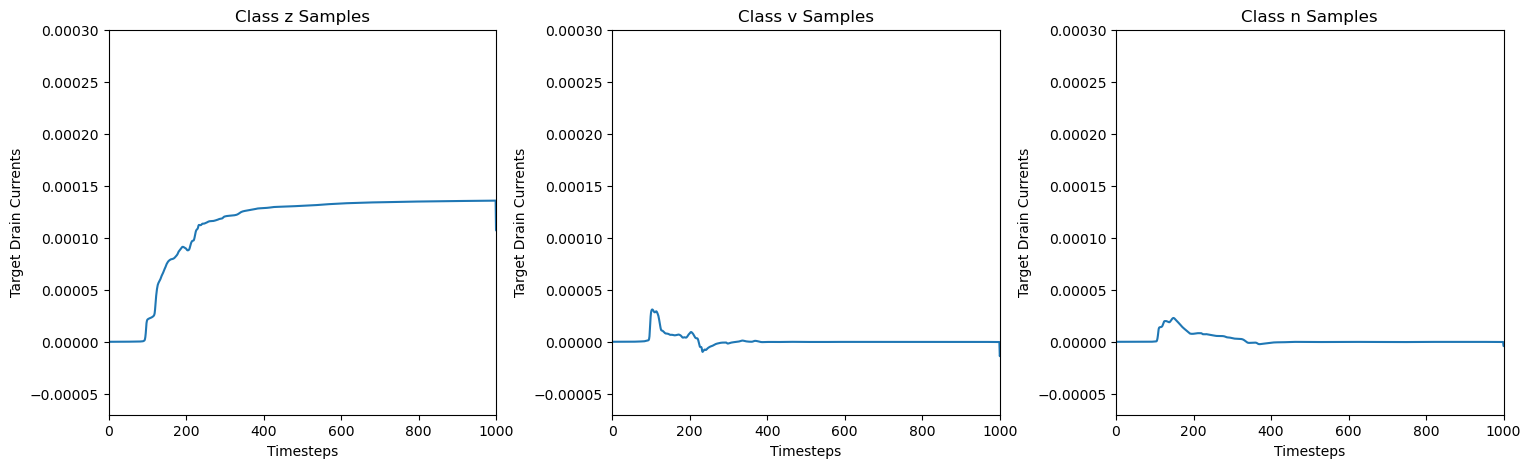

In [39]:
#non-target drains
plt.rcParams.update(plt.rcParamsDefault)

fig,axes=plt.subplots(1,3,figsize=(18,5))
fig.subplots_adjust(wspace=0.3)
i=0
colors=['r','b','g']
for ax in axes.flat:
    tmp=targetClassVals[i]
    ax.plot(sim.electrodeCurrent[:,tmp])
#     ax.legend(np.setdiff1d(target_letters,target_letters[i]))    
    ax.set_title('Class ' +target_letters[i]+' Samples')
    ax.set_xlabel('Timesteps')
    ax.set_ylabel('Target Drain Currents')
#     ax.vlines(range(0,881,110),0,onAmp+0.05,linestyles='dashed',colors='k',alpha=0.5)
    ax.set_ylim([-7e-5,3e-4])
    ax.set_xlim([0,1000])
    i+=1

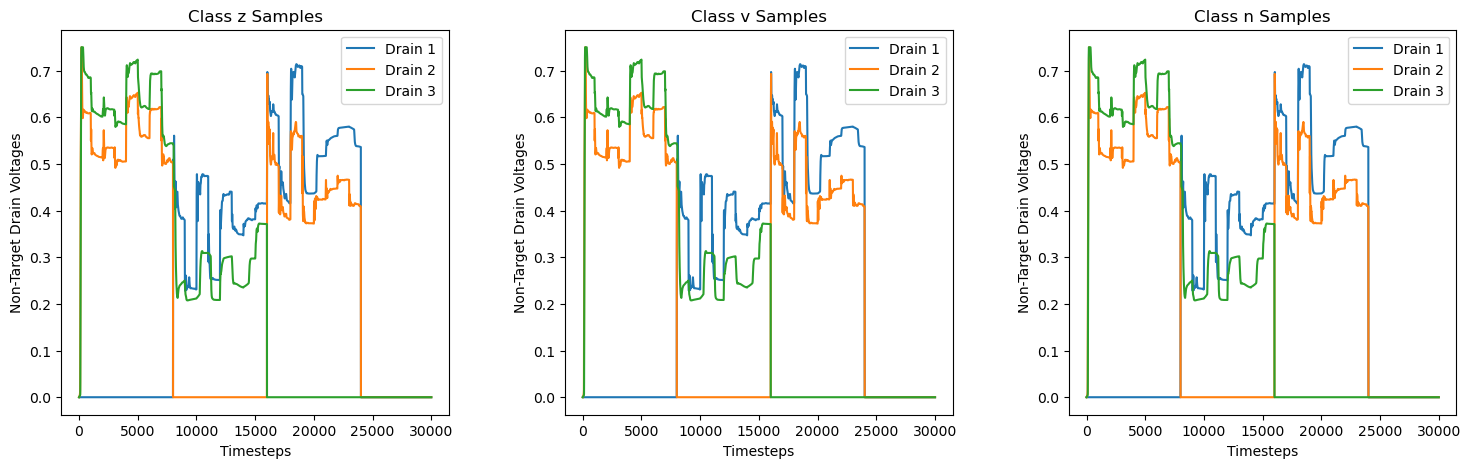

In [40]:
#non-target drains
plt.rcParams.update(plt.rcParamsDefault)

fig,axes=plt.subplots(1,3,figsize=(18,5))
fig.subplots_adjust(wspace=0.3)
i=0
colors=['r','b','g']
for ax in axes.flat:
    tmp=drain_pool#np.setdiff1d(np.array(drain_pool),np.array(drain_pool[i]))
    ax.plot(sim.wireVoltage[:,tmp])
#     ax.legend(np.setdiff1d(target_letters,target_letters[i]))    
    ax.set_title('Class ' +target_letters[i]+' Samples')
    drain_labels=['Drain 1','Drain 2','Drain 3']
#     ax.annotate('Target Drain :' +str(i+1),[0.7,0.1],xycoords='axes fraction')
    ax.legend(drain_labels)#np.setdiff1d(drain_labels,drain_labels[i]),loc='lower left')    
    ax.set_xlabel('Timesteps')
    ax.set_ylabel('Non-Target Drain Voltages')
#     ax.vlines(range(0,881,110),0,onAmp+0.05,linestyles='dashed',colors='k',alpha=0.5)
#     ax.set_ylim([0,onAmp+0.05])
    i+=1

In [60]:
readOutElecs=np.random.choice(350, size=6, replace=False)
if any(x in drain_pool for x in readOutElecs):
    print('Drains are in the randomly chosen elecs')
if any(x in sources for x in readOutElecs):
    print('Sources are in the randomly chosen elecs')

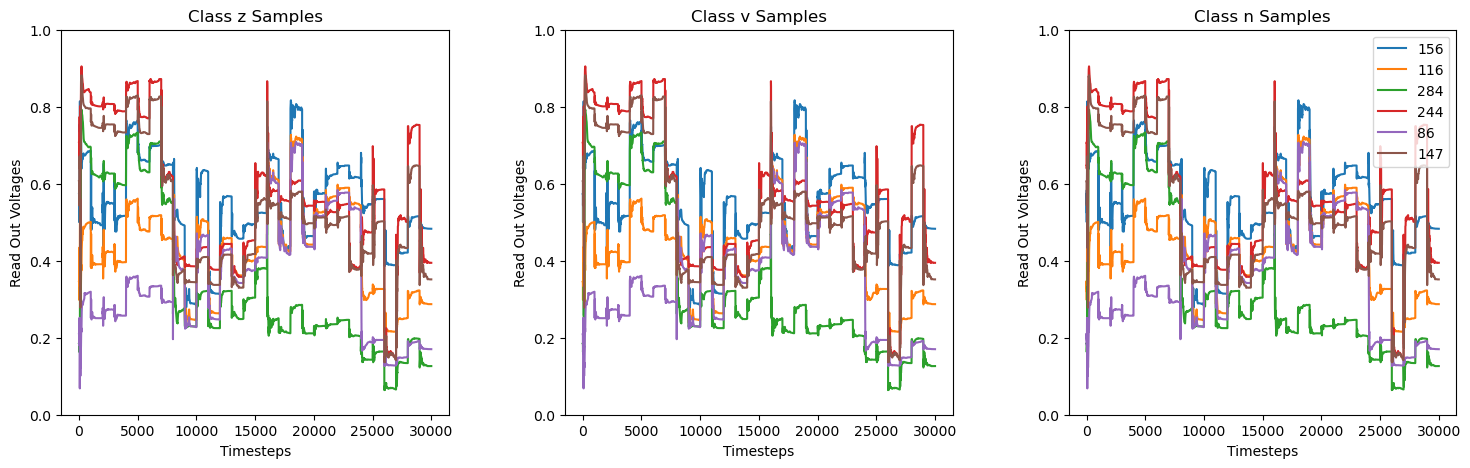

In [61]:
plt.rcParams.update(plt.rcParamsDefault)

fig,axes=plt.subplots(1,3,figsize=(18,5))
fig.subplots_adjust(wspace=0.3)
i=0
for ax in axes.flat:
    ax.plot(sim.wireVoltage[:,readOutElecs])
    plt.legend(readOutElecs)    
    ax.set_title('Class ' +target_letters[i]+' Samples')
#     ax.annotate('Target Drain :' +str(i+1),[0.7,0.1],xycoords='axes fraction')
#     ax.legend(['Drain 1','Drain 2','Drain 3'])
    ax.set_xlabel('Timesteps')
    ax.set_ylabel('Read Out Voltages')
#     ax.vlines(range(0,881,110),0,onAmp+0.05,linestyles='dashed',colors='k',alpha=0.5)
    ax.set_ylim([0,1])
    i+=1

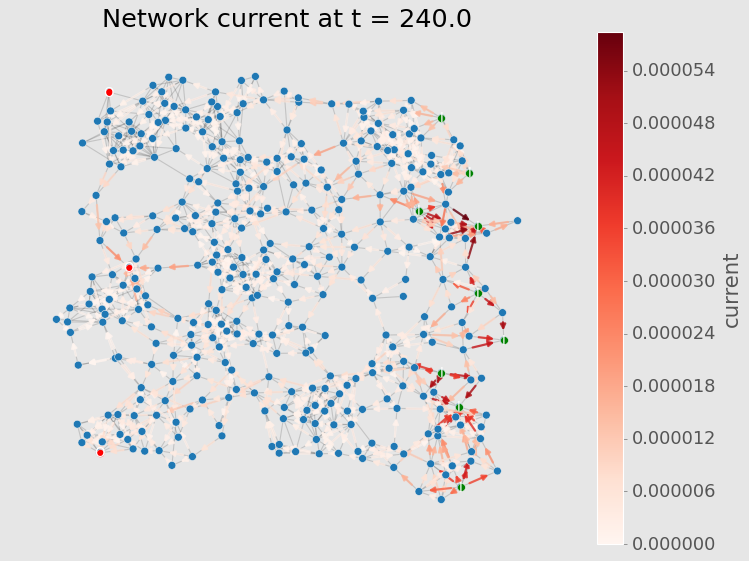

In [80]:
draw_graph(sim,this_TimeStamp,edge_mode='current',edge_colorbar=True,node_size=50,with_labels=False,figsize=(10, 8))
nx.draw_networkx_nodes(G,pos=pos,nodelist=sources,node_color='g',node_size=50)
nx.draw_networkx_nodes(G,pos=pos,nodelist=drain_pool,node_color='r',node_size=50)

### VIDEOS

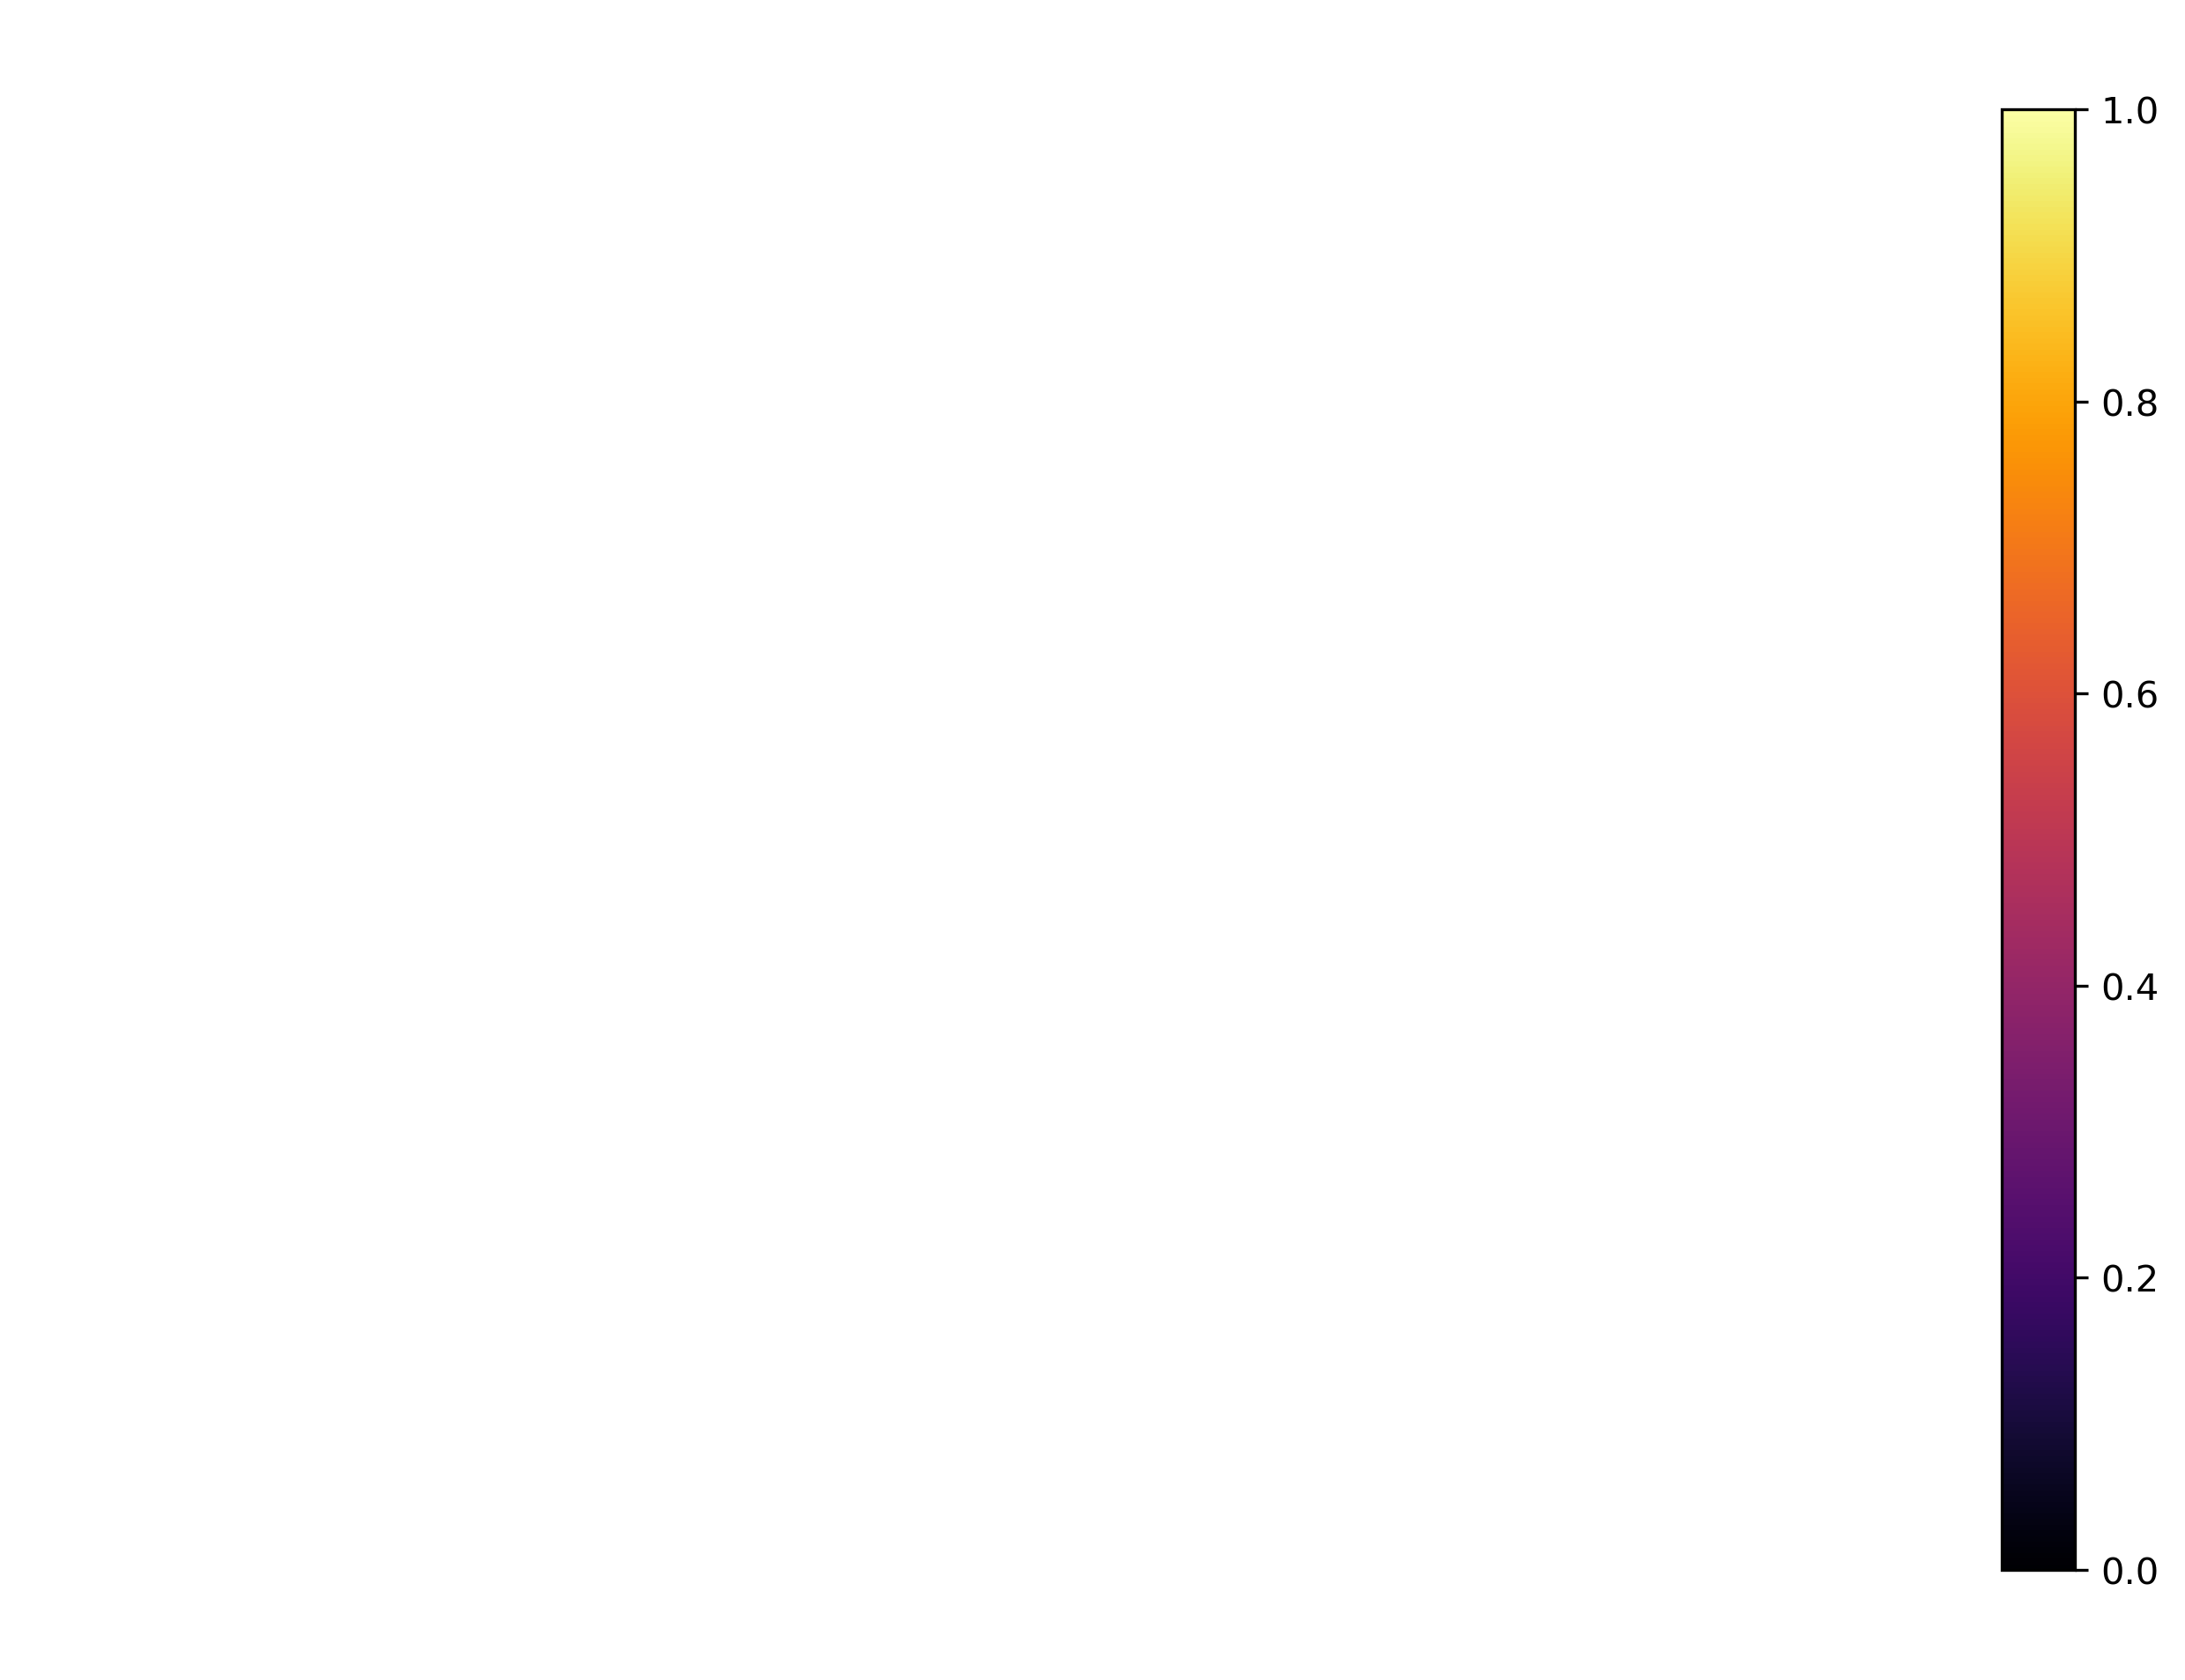

In [142]:
from matplotlib import animation
from PIL import Image
def animate(time): #animate
    image_draw_voltage(time)
    
f,[ax,cax] = plt.subplots(1,2, gridspec_kw={"width_ratios":[50,1]},frameon=False, figsize=(10, 8), dpi=300)
canvas_width, canvas_height = f.canvas.get_width_height()
ax.axis('off')
cax.axis('off')
minWeights=np.min(sim.wireVoltage)
maxWeights=np.max(sim.wireVoltage)

#This is a dirty work around for a colorbar
clrplt=np.linspace(minWeights,maxWeights,2).reshape(2,1)
img=cax.imshow(clrplt,cmap=plt.cm.inferno)
cax.set_visible(False)
plt.colorbar(img,ax=cax,cmap=plt.cm.inferno,fraction=2, pad=0.04)

anim = animation.FuncAnimation(f, animate, frames=range(30000)[::100], interval=100, repeat=False)


In [145]:
cd '/import/silo2/aloe8475/Documents/Data/Figures/Functional Connectivity/'


/import/silo2/aloe8475/Documents/Data/Figures/Functional Connectivity


In [ ]:
from matplotlib import rcParams
rcParams['animation.embed_limit'] = 2**64

#MP4
FFwriter = animation.FFMpegWriter()
anim.save('Voltage_Vid_Backprop.mp4', fps=10)

#GIF
# anim.save(saveFig+'Voltage_Vid_Backprop.gif', writer=animation.PillowWriter(fps=30))

#HTML
# s=anim.to_jshtml(fps=30)
# with open(saveFig+'Voltage_Vid_Backprop.html', "w") as img:
#     img.write(s)

2021-10-26 16:01:34,128:INFO:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2021-10-26 16:01:34,130:INFO:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 3000x2400 -pix_fmt rgba -r 10 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y Voltage_Vid_Backprop.mp4


0.0%

0.0%

3.0%%

In [ ]:
cd '/import/silo2/aloe8475/Documents/CODE/Analysis/Training/Associative Learning/Natesh_3x3/'

In [114]:
#Voltage
def image_draw_voltage(time):
    plt.rcParams.update(plt.rcParamsDefault)
    if time == 0:
        sys.stdout.flush()
        sys.stdout.write("\b" * (30000+1)) # return to start of line, after '['
    sys.stdout.write('\r'+str(np.around((time/30000)*100,2))+'%')
    sys.stdout.flush()
    
    this_TimeStamp=time
    
    data=sim.wireVoltage[this_TimeStamp,:]
    G=nx.from_numpy_array(connectivity.adj_matrix)
    pos=nx.kamada_kawai_layout(G)
    nodes=nx.draw_networkx_nodes(G,pos=pos,node_color=data,cmap=plt.cm.inferno,node_size=150,ax=ax)
    edges=nx.draw_networkx_edges(G,pos=pos,ax=ax)

    # add the bar
#     cbar = plt.colorbar(nodes,label='Voltage',shrink=0.7)


    for i in range(len(sources)):
        x,y=pos[sources[i]]
        ax.text(x+0.1,y,s='Source',size=10, bbox=dict(facecolor='green', alpha=0.3),horizontalalignment='center')

    for i in range(len(drain_pool)):
        x,y=pos[drain_pool[i]]
        ax.text(x-0.1,y,s='Drain',size=10, bbox=dict(facecolor='red', alpha=0.5),horizontalalignment='center')


In [69]:
# #Current
# this_TimeStamp=7990

# fig=plt.figure(figsize=(10,8))

# data=sim.junctionVoltage[this_TimeStamp,:]/sim.junctionResistance[this_TimeStamp,:]
# nodes=nx.draw_networkx_nodes(G,pos=pos,node_size=30)
# nodes=nx.draw_networkx_nodes(G,pos=pos,nodelist=drain_pool,node_color='r',node_size=30)
# nodes=nx.draw_networkx_nodes(G,pos=pos,nodelist=sources,node_color='g',node_size=30)

# edges=nx.draw_networkx_edges(G,pos=pos,edge_color=data,edge_cmap=plt.cm.RdBu_r,node_size=10)

# # cbnorm = clrs.SymLogNorm(1,1,vmin = min(data), vmax = max(data))
# # cbnorm._transform_vmin_vmax()
# # edges.set_norm(cbnorm)
# cbar = plt.colorbar(edges,label='Current',shrink=0.7)

# plt.show()


In [1025]:
# repeats=1
# target=np.hstack((np.ones(880),np.ones(880)*2,np.ones(880)*3)).T
# data=np.vstack((sim[0].wireVoltage[:,readOutElecs],sim[1].wireVoltage[:,readOutElecs],sim[2].wireVoltage[:,readOutElecs]))

# T, N = data.shape #num readouts
# accuracy = np.zeros(repeats)
# weight = np.zeros((repeats, numReadOuts+1))
# result = np.zeros((repeats, T))    
    
# lhs = data
# rhs = target
# #             set_trace()
# weight = np.linalg.lstsq(lhs, rhs, rcond = None)[0]
# result = np.matmul(lhs, weight)
# accuracy=(1-getRNMSE(result, rhs))

In [351]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

clf = LinearDiscriminantAnalysis()
clf.fit(lhs, rhs)

LinearDiscriminantAnalysis()

In [355]:
a=sum(clf.predict(sim[0].wireVoltage[:,readOutElecs])==1)/len(sim[0].wireVoltage[:,readOutElecs])

In [356]:
b=sum(clf.predict(sim[1].wireVoltage[:,readOutElecs])==2)/len(sim[1].wireVoltage[:,readOutElecs])

In [357]:
c=sum(clf.predict(sim[2].wireVoltage[:,readOutElecs])==3)/len(sim[2].wireVoltage[:,readOutElecs])

In [358]:
np.mean([a,b,c])

0.8215909090909091

In [396]:
#ADD BACKPROP

In [25]:
#This function runs each training epoch and saves the network state at the last timestep of that epoch

def getNWState_backprop(training_stimulus,state,drains,sources,run_time=2,disable_tqdm=False):
    eles = np.append(drains, sources) #all drains
#     if len(eles) == num_drain_training + num_source_training:
    training_sim,cost = runSim_backprop(connectivity, stimulus = training_stimulus,
                       junctionMode = 'tunneling',
                       dt = dt, T = run_time, 
                       contactMode = 'preSet',
                       electrodes = eles,
                       findFirst = False,
                       start_state = state,
                       disable_tqdm=disable_tqdm)
                       #criticalFlux=0.01)  
#     JS1 = getJunctionState(training_sim, -1) #save state
#     else: 
#         print('Bless you Joel :)')
    return training_sim,cost

In [24]:
#Combine drain voltage change with runSim:
def runSim_backprop(Connectivity, 
                    junctionMode='binary', collapse=False,
                    criticalFlux=1e-1, maxFlux=1.5e-1,
                    contactMode='farthest', electrodes=None,
                    dt=1e-3, T=10, 
                    stimulus = None,
                    biasType = 'DC',
                    onTime=0, offTime=50000000,
                    onAmp=1, offAmp=0.005,
                    f = 1, customSignal = None,
                    start_state = None,
                    lite_mode = False, save_steps = 1,
                    findFirst = True,
                    disable_tqdm = False,
                    freeze_wire = None, freeze_junction = None, 
                    freeze_TimeStamp = None):

    """
    For the case of multi electrodes, stimulus should be in parameters.
    See help(stimulus__) for how to generate stimulus__ objects.
    """

    SimulationOptions = simulationOptions__(dt = dt, T = T,
                                            connectivity = Connectivity, 
                                            contactMode = contactMode,
                                            electrodes = electrodes)

    if ((contactMode == 'preSet') and (len(electrodes) > 2)) or stimulus is not None:
        from sys import exit
        if stimulus == None:
            logging.warning(f'Multiple electrodes detected. Please input stimulus in parameters!')
            exit()
        if len(stimulus) < len(SimulationOptions.electrodes):
            diff = len(SimulationOptions.electrodes) - len(stimulus)
            for _ in range(diff):
                stimulus.append(stimulus__('Drain', T = T, dt = dt))

        if len(stimulus) > len(SimulationOptions.electrodes):
            logging.warning(f'More stimulus than electrodes. Current setup has {len(SimulationOptions.electrodes)} electrodes!')
            exit()
            
        if len(stimulus[0].signal) < len(SimulationOptions.TimeVector):
            logging.warning(f'Stimulus length not correct, current time vector has length {len(SimulationOptions.TimeVector)}!')
            exit()
        SimulationOptions.stimulus = stimulus
            
    elif contactMode == 'boundary':
        SimulationOptions.stimulus[:int(len(SimulationOptions.electrodes)/2)] = [stimulus__(biasType = biasType, 
                                                                                        T = T, dt = dt,
                                                                                        onTime = onTime, offTime = offTime,
                                                                                        onAmp = onAmp, offAmp = offAmp,
                                                                                        f = f, customSignal= customSignal)
                                                                                        for i in range(int(len(SimulationOptions.electrodes)/2))]
    else:
        SimulationOptions.stimulus[0] = stimulus__(biasType = biasType, 
                                                T = T, dt = dt,
                                                onTime = onTime, offTime = offTime,
                                                onAmp = onAmp, offAmp = offAmp,
                                                    f = f, customSignal= customSignal)
    if start_state == None: 
        JunctionState = junctionState__(Connectivity.numOfJunctions, 
                                    mode = junctionMode, collapse = collapse, 
                                    criticalFlux=criticalFlux, maxFlux = maxFlux)
    else:
        from copy import deepcopy
        JunctionState = deepcopy(start_state)
    
    kwdict = dict()
    if (freeze_wire != None) or (freeze_junction != None):
        kwdict = dict(freeze_wire = freeze_wire,
                    freeze_junction = freeze_junction, 
                    freeze_TimeStamp = freeze_TimeStamp)
        
    this_realization,cost = simulateNetwork_backprop(SimulationOptions, Connectivity, JunctionState, lite_mode, disable_tqdm, save_steps, **kwdict)
    
    if findFirst:
        from edamame.analysis.GraphTheory import findCurrent
        try:
            activation = findCurrent(this_realization, 1)
            logging.info(f'First current path {activation[0][0]} formed at time = {activation[1][0]} s.')
        except:
            logging.info('Unfortunately, no current path is formed in simulation time.')

    return this_realization,cost

In [36]:
def simulateNetwork_backprop(simulationOptions, connectivity, junctionState, lite_mode = False, disable_tqdm = False, save_steps = 1, **kwargs):
    niterations = simulationOptions.NumOfIterations
    electrodes = simulationOptions.electrodes
    numOfElectrodes = len(electrodes)
    E = connectivity.numOfJunctions
    V = connectivity.numOfWires
    edgeList = connectivity.edge_list
    
    maxV      = onAmp
    n         = num_drain_training #num of drains
    cost      = []
    beta      = 0.1 
    grad      = np.zeros((n)) #set gradients to zero for each epoch  

    Network = network__()
    sampling = np.arange(0, niterations, save_steps)
    if lite_mode:
        Network.connectivity = connectivity__(adjMat = connectivity.adj_matrix)
        Network.filamentState = np.zeros((int(niterations/save_steps), E))
        Network.wireVoltage = np.zeros((int(niterations/save_steps), V))
        Network.electrodeCurrent = np.zeros((int(niterations/save_steps), numOfElectrodes))
        Network.TimeVector = np.zeros(int(niterations/save_steps))
    else:        
        Network.connectivity = connectivity
        Network.TimeVector = simulationOptions.TimeVector
        Network.filamentState = np.zeros((niterations, E))
        Network.junctionVoltage = np.zeros((niterations, E))
        # Network.junctionResistance = np.zeros((niterations, E))
        Network.junctionConductance = np.zeros((niterations, E))
        Network.junctionSwitch = np.zeros((niterations, E), dtype = bool)
        Network.wireVoltage = np.zeros((niterations, V))
        Network.electrodeCurrent = np.zeros((niterations, numOfElectrodes))

    Network.sources = []
    Network.drains = []
    for i in range(numOfElectrodes):
        if np.mean(simulationOptions.stimulus[i].signal) != 0:
            Network.sources.append(electrodes[i])
        else:
            Network.drains.append(electrodes[i])

    if len(Network.drains) == 0:
        Network.drains.append(electrodes[1])

    if 'freeze_wire' in kwargs:
        freeze_wire = kwargs['freeze_wire']
        freeze_TimeStamp = kwargs['freeze_TimeStamp']
    else:
        freeze_TimeStamp = niterations + 1
    
    for this_time in tqdm(range(niterations), desc='Running Simulation ', disable = disable_tqdm): #each time step
        this_stimulus = np.array([i.signal[this_time] for i in simulationOptions.stimulus])
        if this_time == 0:
            print('--------')
            print('Training')
            print('--------\n')
        if this_time > 0 and this_time < trainTime: #if we are training, change drain voltages, otherwise just use this_stimulus
            this_stimulus[:3]=new_stimulus 
        elif this_time == trainTime:
            print('--------')
            print('Testing')
            print('--------\n')
#             print('in training '+str(this_time))
#         elif this_time > trainTime:
            
        sol = simCore(connectivity, junctionState, this_stimulus, electrodes, simulationOptions.dt)

        if this_time >= freeze_TimeStamp:
            others = np.setdiff1d(range(V), freeze_wire)
            wireVoltage[others] = sol[others]
        else:
            wireVoltage = sol[0:V]
            
        if lite_mode:
            if this_time%save_steps == 0:
                Network.wireVoltage[this_time//save_steps,:] = wireVoltage
                Network.electrodeCurrent[this_time//save_steps,:] = sol[V:]
                Network.filamentState[this_time//save_steps,:] = junctionState.filamentState
                Network.TimeVector[this_time//save_steps] = simulationOptions.TimeVector[this_time]
        else:
            Network.wireVoltage[this_time,:] = wireVoltage
            Network.electrodeCurrent[this_time,:] = sol[V:]
            Network.filamentState[this_time,:] = junctionState.filamentState
            Network.junctionVoltage[this_time,:] = junctionState.voltage
            Network.junctionConductance[this_time,:] = junctionState.conductance
            Network.junctionSwitch[this_time,:] = junctionState.OnOrOff
        
        ## BackProp Implementation
        y = Network.electrodeCurrent[this_time,:num_drain_training]
        y = y/(maxCurrent[tmpTargets[this_time]]) # normalize  | | | how do we change max current to be not arbitrary? 
        # current method - run simulation before with just that drain and use current as maxCurrent
        
        # change to threshold 
        d = allTargets[tmpTargets[this_time]]
        dsig = this_stimulus[:num_drain_training]
        
        
        #vectorised implementation
        cost.append(calc_cost(y,d))
        
        if this_time < trainTime: #if we are training, update beta
            #Gradient without considering other electrodes:
    # 
            grad=beta*(y-d) #e.g. [y1 vs (d1 = 1), y2 vs (d2 = 0), y3vs (d3 = 0)]
            #Gradient while considering other electrodes:
    #         for i in range(n): #for each drain 
                #y = normalised drain current
                #d = target (1 or 0) e.g. [1,0,0]

    #             grad[i] = beta*(y[i]-d[i]) + sum([beta*(y[j]-d[j]) for j in range(n) if j != i])
                # i = 1, drain 1 is target, target = 1
                # i = 2, drain 2 is target, target = 0

            #grad_i = (y_i - d_i) + SUM[ beta*(y_j - d_j) ], j \neq (doesn't equal) i        
            dsig2=np.array(dsig.T+(grad*onAmp))

            dsig2[tmpTargets[this_time]]=0
            new_stimulus=dsig2
            
            for q in range(n): # for each drain:
                if dsig2[q] <= maxV and dsig2[q] >= -maxV:
                    new_stimulus[q]=dsig2[q]
                elif dsig2[q] < -maxV:
                    new_stimulus[q]=-maxV
                elif dsig2[q] > maxV:
                    new_stimulus[q]=maxV  
                    
            tmp=range(0,niterations,3000)
            if this_time in tmp:
                print('Target ' +str(d))
                print('Drain V '+str(dsig2))
                
            ##    
    Network.numOfWires = V
    Network.numOfJunctions = E
    Network.electrodes = simulationOptions.electrodes
    if len(electrodes) <= 2:
        Network.conductance = Network.electrodeCurrent[:,1]/simulationOptions.stimulus[0].signal[sampling]
    if not lite_mode:
        Network.stimulus = [simulationOptions.stimulus[i] for i in range(numOfElectrodes)]
        Network.junctionResistance = 1/Network.junctionConductance
        
    return Network,cost